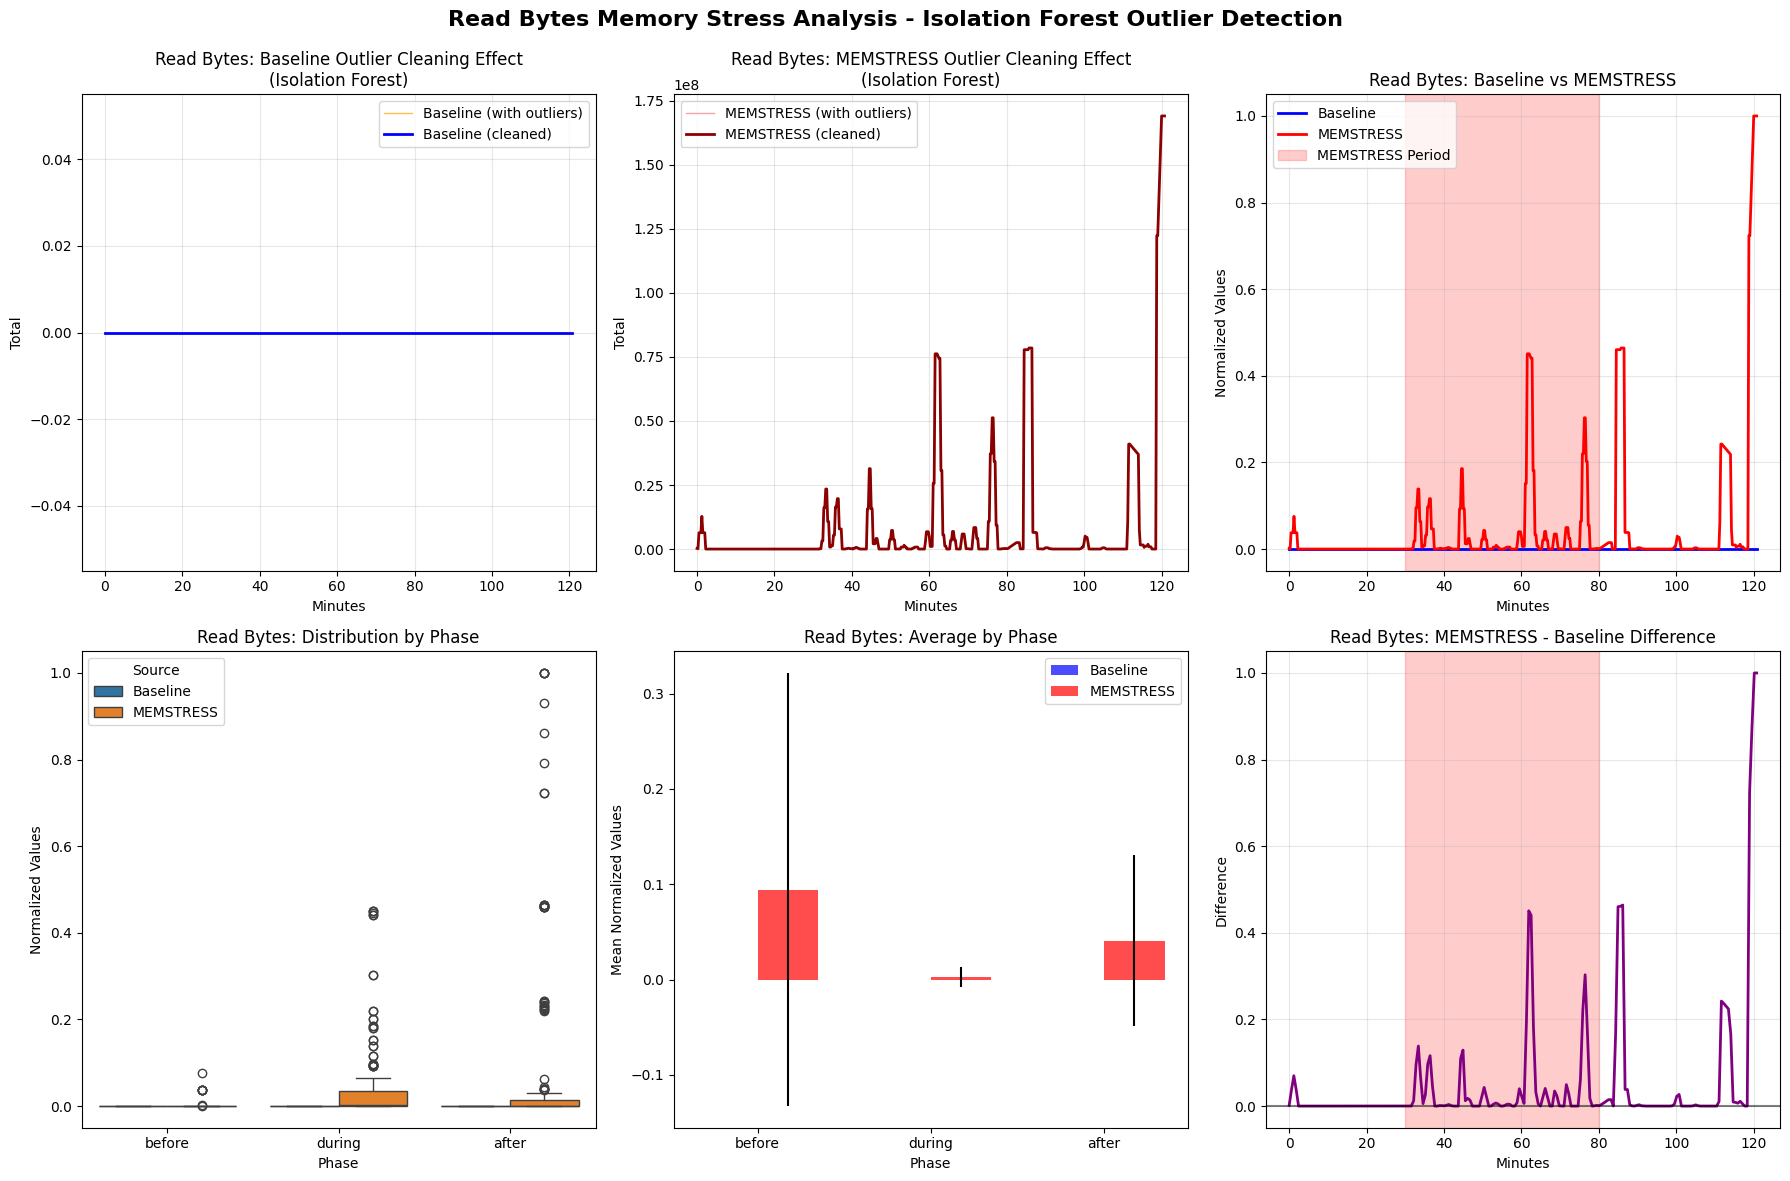


📊 READ BYTES STATISTICAL ANALYSIS:

BEFORE phase:
  Baseline: mean=0.0000, std=0.0000
  MEMSTRESS: mean=0.0025, std=0.0106
  Change: +0.00%
  T-test: t=-2.609, p=0.0097 (✅ SIGNIFICANT)

DURING phase:
  Baseline: mean=0.0000, std=0.0000
  MEMSTRESS: mean=0.0409, std=0.0896
  Change: +0.00%
  T-test: t=-6.462, p=0.0000 (✅ SIGNIFICANT)

AFTER phase:
  Baseline: mean=0.0000, std=0.0000
  MEMSTRESS: mean=0.0945, std=0.2271
  Change: +0.00%
  T-test: t=-5.312, p=0.0000 (✅ SIGNIFICANT)


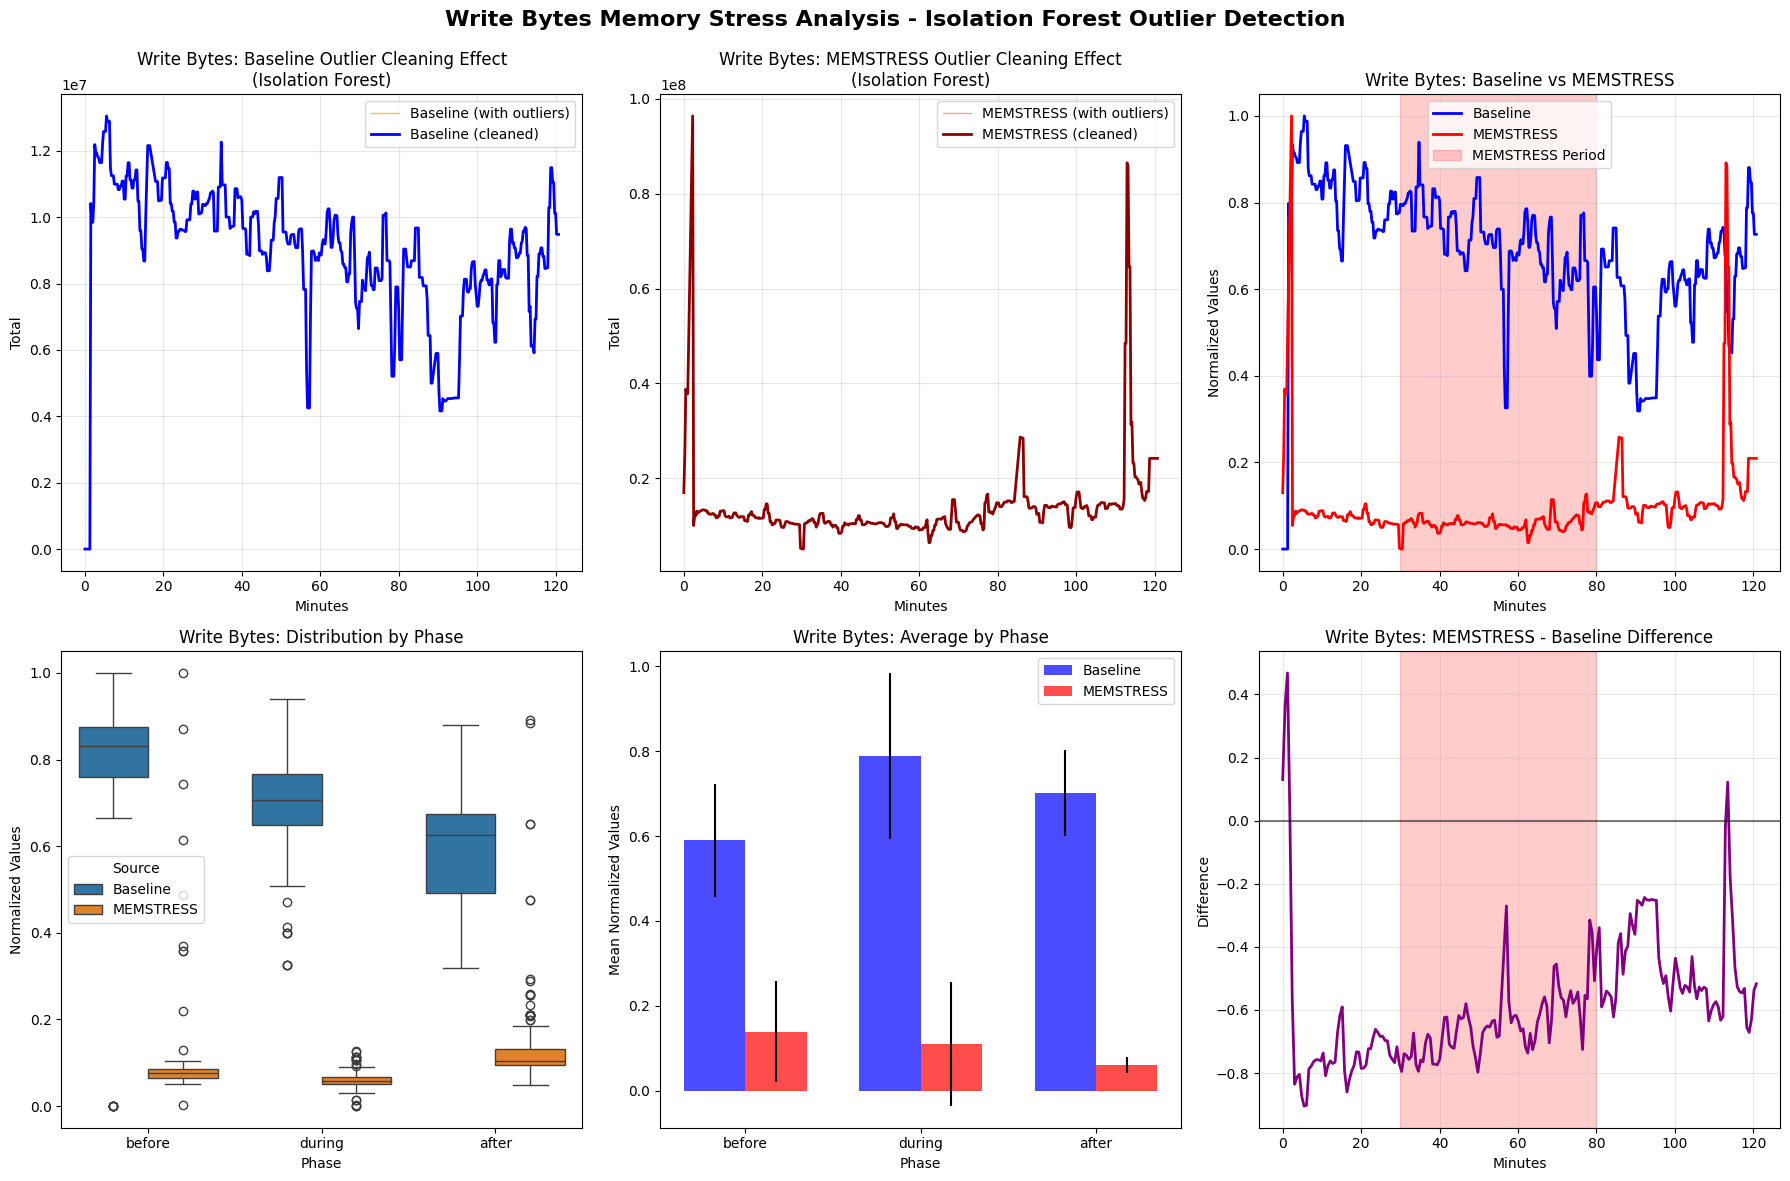


📊 WRITE BYTES STATISTICAL ANALYSIS:

BEFORE phase:
  Baseline: mean=0.7895, std=0.1952
  MEMSTRESS: mean=0.1098, std=0.1462
  Change: -86.09%
  T-test: t=30.526, p=0.0000 (✅ SIGNIFICANT)

DURING phase:
  Baseline: mean=0.7008, std=0.1011
  MEMSTRESS: mean=0.0606, std=0.0185
  Change: -91.35%
  T-test: t=88.275, p=0.0000 (✅ SIGNIFICANT)

AFTER phase:
  Baseline: mean=0.5898, std=0.1326
  MEMSTRESS: mean=0.1388, std=0.1188
  Change: -76.47%
  T-test: t=32.340, p=0.0000 (✅ SIGNIFICANT)


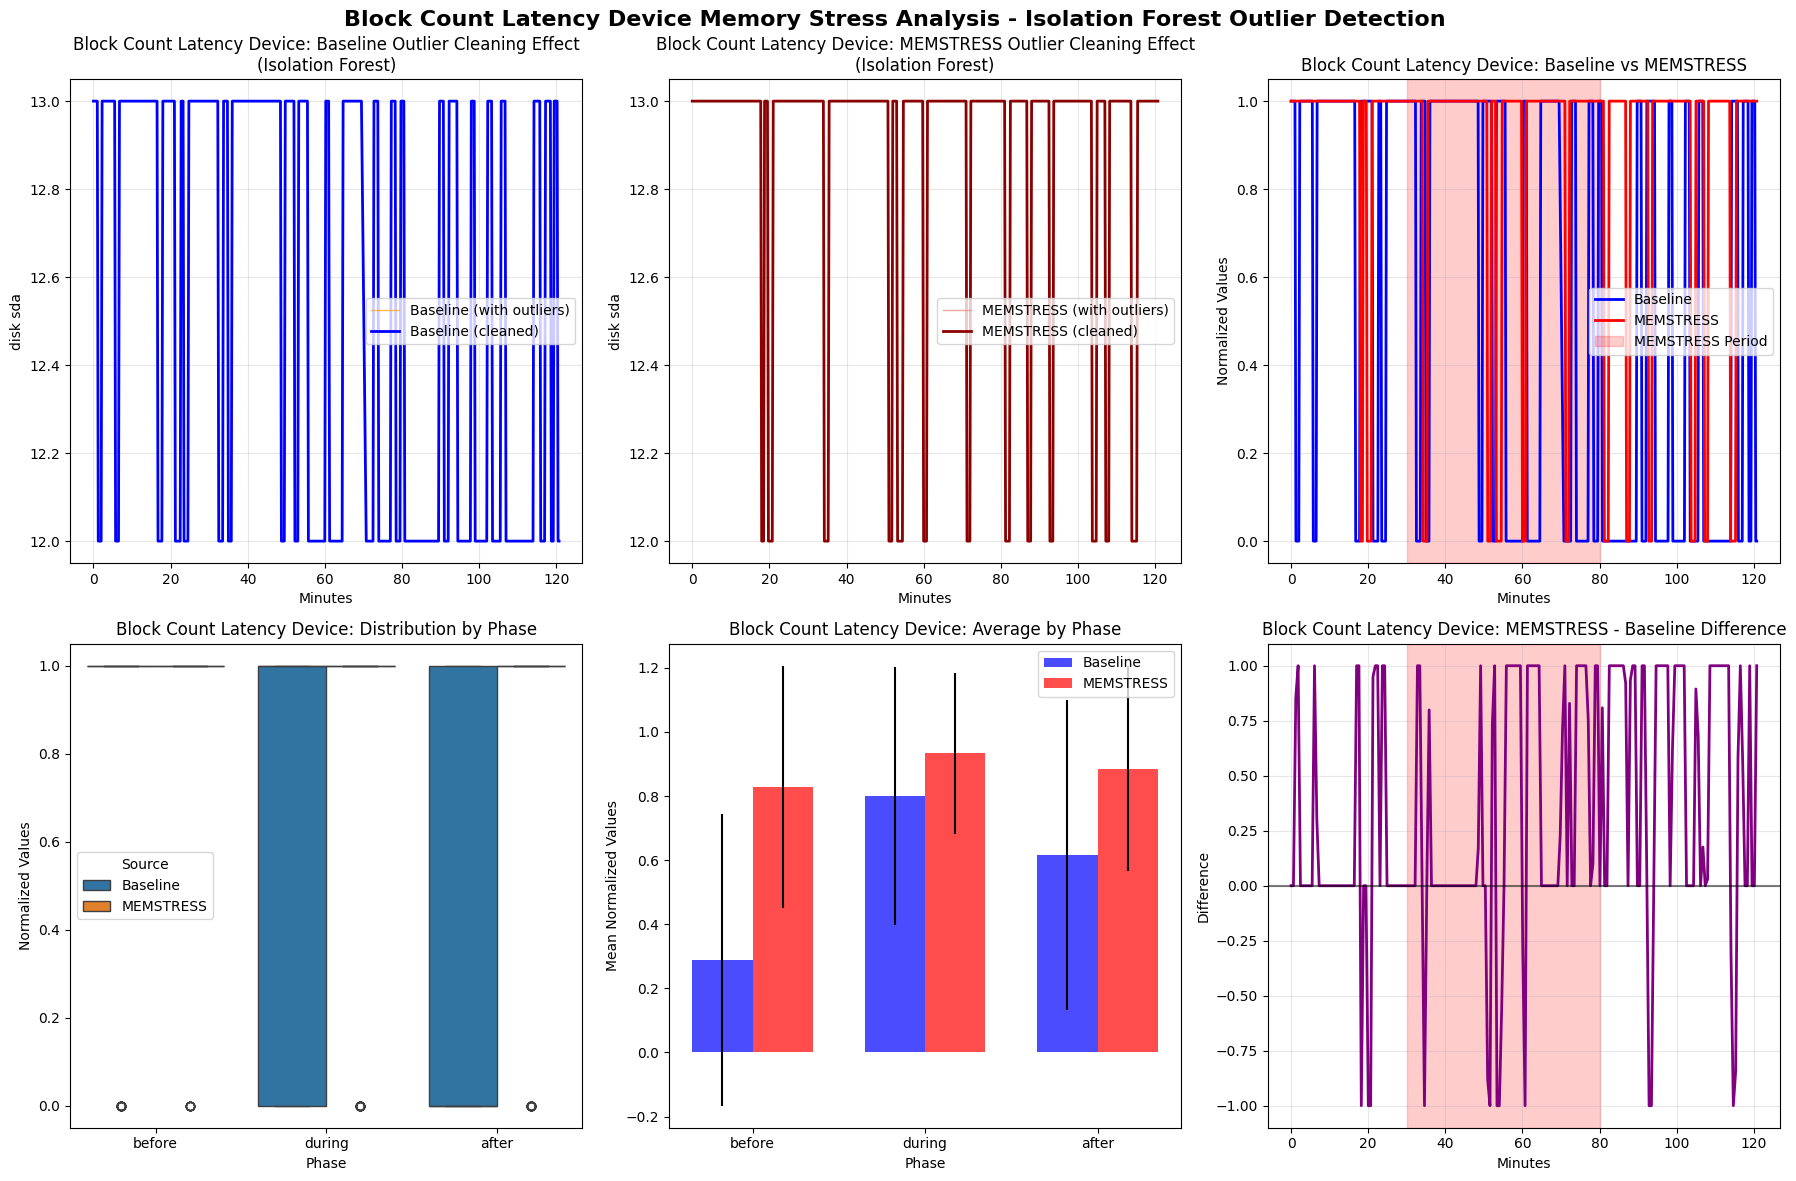


📊 BLOCK COUNT LATENCY DEVICE STATISTICAL ANALYSIS:

BEFORE phase:
  Baseline: mean=0.8000, std=0.4017
  MEMSTRESS: mean=0.9333, std=0.2505
  Change: +16.67%
  T-test: t=-3.085, p=0.0023 (✅ SIGNIFICANT)

DURING phase:
  Baseline: mean=0.6169, std=0.4832
  MEMSTRESS: mean=0.8856, std=0.3191
  Change: +43.55%
  T-test: t=-6.577, p=0.0000 (✅ SIGNIFICANT)

AFTER phase:
  Baseline: mean=0.2883, std=0.4544
  MEMSTRESS: mean=0.8282, std=0.3784
  Change: +187.23%
  T-test: t=-11.657, p=0.0000 (✅ SIGNIFICANT)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

df_block_count_latency_device = pd.read_csv("block_count_latency_device.csv")
df_read_bytes = pd.read_csv("read_bytes.csv")
df_write_bytes = pd.read_csv("write_bytes.csv")

df_baseline_block_count_latency_device = pd.read_csv("../../baseline/IO related/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("../../baseline/IO related/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("../../baseline/IO related/write_bytes.csv")

df_block_count_latency_device["source"] = "MEMSTRESS"
df_read_bytes["source"] = "MEMSTRESS"
df_write_bytes["source"] = "MEMSTRESS"

df_baseline_block_count_latency_device["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"

datasets = [
    df_block_count_latency_device, df_read_bytes, df_write_bytes,
    df_baseline_block_count_latency_device, df_baseline_read_bytes, df_baseline_write_bytes
]

for df in datasets:
    df["Time"] = pd.to_datetime(df["Time"])
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

delay = 30
duration = 50

def remove_outliers_isolation_forest(df, contamination=0.04):
    df_clean = df.copy()
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        return df_clean
    
    feature_matrix = df[numeric_cols].fillna(0).values
    
    if np.std(feature_matrix.flatten()) > 1e-10:
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        iso_forest = IsolationForest(
            contamination=contamination,
            n_estimators=150,
            random_state=42,
            n_jobs=-1
        )
        
        iso_forest.fit(feature_matrix_scaled)
        outlier_predictions = iso_forest.predict(feature_matrix_scaled)
        outlier_mask = outlier_predictions == -1
        
        for col in numeric_cols:
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear').fillna(0)
    
    return df_clean

df_block_count_latency_device = remove_outliers_isolation_forest(df_block_count_latency_device)
df_read_bytes = remove_outliers_isolation_forest(df_read_bytes)
df_write_bytes = remove_outliers_isolation_forest(df_write_bytes)

df_baseline_block_count_latency_device = remove_outliers_isolation_forest(df_baseline_block_count_latency_device)
df_baseline_read_bytes = remove_outliers_isolation_forest(df_baseline_read_bytes)
df_baseline_write_bytes = remove_outliers_isolation_forest(df_baseline_write_bytes)

def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

def define_phases(df, delay_minutes, duration_minutes):
    conditions = [
        df['Minutes'] < delay_minutes,
        (df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes),
        df['Minutes'] > delay_minutes + duration_minutes
    ]
    choices = ['before', 'during', 'after']
    df['Phase'] = np.select(conditions, choices, default='unknown')
    return df

def analyze_io_dataset_complete(baseline_df, test_df, dataset_name, test_label="MEMSTRESS"):
    numeric_cols = [col for col in baseline_df.columns 
                   if col not in ['Time', 'Minutes', 'source', 'Phase'] and baseline_df[col].dtype in ['int64', 'float64']]
    
    if not numeric_cols:
        return
    
    if len(numeric_cols) > 1:
        baseline_df['Total'] = baseline_df[numeric_cols].sum(axis=1)
        test_df['Total'] = test_df[numeric_cols].sum(axis=1)
        main_col = 'Total'
    else:
        main_col = numeric_cols[0]
    
    baseline_norm = normalize_df(baseline_df, [main_col])
    test_norm = normalize_df(test_df, [main_col])
    
    baseline_norm = define_phases(baseline_norm, delay, duration)
    test_norm = define_phases(test_norm, delay, duration)
    
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle(f'{dataset_name} Memory Stress Analysis - Isolation Forest Outlier Detection', fontsize=16, fontweight='bold')
    
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(baseline_df['Minutes'], baseline_df[main_col], color='orange', alpha=0.7, linewidth=1, label=f'Baseline (with outliers)')
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_col] * (baseline_df[main_col].max() - baseline_df[main_col].min()) + baseline_df[main_col].min(), 
             color='blue', linewidth=2, label='Baseline (cleaned)')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect\n(Isolation Forest)')
    plt.xlabel('Minutes')
    plt.ylabel(f'{main_col}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(2, 3, 2)
    plt.plot(test_df['Minutes'], test_df[main_col], color='lightcoral', alpha=0.7, linewidth=1, label=f'{test_label} (with outliers)')
    plt.plot(test_norm['Minutes'], test_norm[main_col] * (test_df[main_col].max() - test_df[main_col].min()) + test_df[main_col].min(), 
             color='darkred', linewidth=2, label=f'{test_label} (cleaned)')
    plt.title(f'{dataset_name}: {test_label} Outlier Cleaning Effect\n(Isolation Forest)')
    plt.xlabel('Minutes')
    plt.ylabel(f'{main_col}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    ax3 = plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_col], color='blue', linewidth=2, label='Baseline')
    plt.plot(test_norm['Minutes'], test_norm[main_col], color='red', linewidth=2, label=test_label)
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label=f'{test_label} Period')
    plt.title(f'{dataset_name}: Baseline vs {test_label}')
    plt.xlabel('Minutes')
    plt.ylabel('Normalized Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    baseline_phase_data = []
    test_phase_data = []
    phases = ['before', 'during', 'after']
    
    for phase in phases:
        baseline_phase_values = baseline_norm[baseline_norm['Phase'] == phase][main_col]
        test_phase_values = test_norm[test_norm['Phase'] == phase][main_col]
        
        baseline_phase_data.extend([(phase, val, 'Baseline') for val in baseline_phase_values])
        test_phase_data.extend([(phase, val, test_label) for val in test_phase_values])
    
    all_phase_data = baseline_phase_data + test_phase_data
    phase_df = pd.DataFrame(all_phase_data, columns=['Phase', 'Value', 'Source'])
    
    ax4 = plt.subplot(2, 3, 4)
    sns.boxplot(data=phase_df, x='Phase', y='Value', hue='Source', ax=ax4)
    plt.title(f'{dataset_name}: Distribution by Phase')
    plt.ylabel('Normalized Values')
    plt.xlabel('Phase')
    
    ax5 = plt.subplot(2, 3, 5)
    phase_means = phase_df.groupby(['Phase', 'Source'])['Value'].agg(['mean', 'std']).reset_index()
    
    x_pos = np.arange(len(phases))
    width = 0.35
    
    baseline_means = phase_means[phase_means['Source'] == 'Baseline']['mean'].values
    baseline_stds = phase_means[phase_means['Source'] == 'Baseline']['std'].values
    test_means = phase_means[phase_means['Source'] == test_label]['mean'].values
    test_stds = phase_means[phase_means['Source'] == test_label]['std'].values
    
    plt.bar(x_pos - width/2, baseline_means, width, yerr=baseline_stds, label='Baseline', color='blue', alpha=0.7)
    plt.bar(x_pos + width/2, test_means, width, yerr=test_stds, label=test_label, color='red', alpha=0.7)
    
    plt.title(f'{dataset_name}: Average by Phase')
    plt.ylabel('Mean Normalized Values')
    plt.xlabel('Phase')
    plt.xticks(x_pos, phases)
    plt.legend()
    
    ax6 = plt.subplot(2, 3, 6)
    
    common_minutes = np.linspace(0, min(baseline_norm['Minutes'].max(), test_norm['Minutes'].max()), 200)
    baseline_interp = np.interp(common_minutes, baseline_norm['Minutes'], baseline_norm[main_col])
    test_interp = np.interp(common_minutes, test_norm['Minutes'], test_norm[main_col])
    difference = test_interp - baseline_interp
    
    plt.plot(common_minutes, difference, color='purple', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label=f'{test_label} Period')
    plt.title(f'{dataset_name}: {test_label} - Baseline Difference')
    plt.xlabel('Minutes')
    plt.ylabel('Difference')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 {dataset_name.upper()} STATISTICAL ANALYSIS:")
    print("=" * 50)
    
    for phase in phases:
        baseline_phase_values = baseline_norm[baseline_norm['Phase'] == phase][main_col].dropna()
        test_phase_values = test_norm[test_norm['Phase'] == phase][main_col].dropna()
        
        if len(baseline_phase_values) > 5 and len(test_phase_values) > 5:
            t_stat, p_value = scipy_stats.ttest_ind(baseline_phase_values, test_phase_values)
            significance = "✅ SIGNIFICANT" if p_value < 0.05 else "❌ NOT SIGNIFICANT"
            
            baseline_mean = baseline_phase_values.mean()
            test_mean = test_phase_values.mean()
            change = ((test_mean - baseline_mean) / baseline_mean * 100) if baseline_mean != 0 else 0
            
            print(f"\n{phase.upper()} phase:")
            print(f"  Baseline: mean={baseline_mean:.4f}, std={baseline_phase_values.std():.4f}")
            print(f"  {test_label}: mean={test_mean:.4f}, std={test_phase_values.std():.4f}")
            print(f"  Change: {change:+.2f}%")
            print(f"  T-test: t={t_stat:.3f}, p={p_value:.4f} ({significance})")

datasets_to_analyze = [
    (df_baseline_read_bytes, df_read_bytes, "Read Bytes"),
    (df_baseline_write_bytes, df_write_bytes, "Write Bytes"), 
    (df_baseline_block_count_latency_device, df_block_count_latency_device, "Block Count Latency Device")
]

for baseline_df, test_df, dataset_name in datasets_to_analyze:
    analyze_io_dataset_complete(baseline_df, test_df, dataset_name, "MEMSTRESS")